In [2]:
!hostname

cn6


In [3]:
import torch.nn as nn
import tensorflow as tf
import functools
import torch
import numpy as np
from scipy import special as sf
from scipy.stats import binom as spbinom
from numba import njit,float64,int64,jit
from numba.types import UniTuple
from matplotlib import pyplot as plt
import numba_scipy
import gc
import os
from utils import save_checkpoint_withEval as save_checkpoint
from utils import restore_checkpoint_withEval as restore_checkpoint
from loadDataPipeline import generateData

In [4]:
relu = nn.functional.softplus

In [5]:
from torch.utils.cpp_extension import load
from models import ncsnpp
from configs.vp import cifar10_ncsnpp_continuous as configLoader
from models import utils as mutils
from models.ema import ExponentialMovingAverage

No ROCm runtime is found, using ROCM_HOME='/opt/rocm-5.3.0'


### Loading the ML model from Song et al.

In [6]:
config =  configLoader.get_config()
config.training.batch_size=256
config.training.snapshot_freq_for_preemption=1000
config.training.snapshot_freq=50000
config.training.log_freq=100

In [7]:
tEnd = 15.
T = 1000

In [8]:
config.model.num_scales=T

### Loading the dataset

In [9]:
train_ds, eval_ds, scaler = generateData(config,'cifar10')

train_iter = iter(train_ds)
eval_iter = iter(eval_ds)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

/home/yentingl/torchSDE/lib/python3.7/site-packages/urllib3/connectionpool.py:1052: InsecureRequestWarning: Unverified HTTPS request is being made to host 'proxyout.lanl.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


0 examples [00:00, ? examples/s]

Shuffling and writing examples to dataBuffer/cifar10/3.0.2.incomplete4QG1TR/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to dataBuffer/cifar10/3.0.2.incomplete4QG1TR/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to dataBuffer/cifar10/3.0.2. Subsequent calls will reuse this data.


### Solving for observation times (noise schedule) and forward solution

In [11]:
try:

    data = np.load('20221102-linearDegradation-cifar10-newSchedule-files.npz', allow_pickle=True)
    cumSolArray=data['cumSolArray']
    brTable=data['brTable']
    observationTimes=data['observationTimes']    
    
except FileNotFoundError:

    from scipy.optimize import bisect

    def f(x):
        return np.log(x/(1-x))

    xEnd = np.exp(-tEnd)
    fGrid = np.linspace(-f(xEnd), f(xEnd), T)
    xGrid = np.array([bisect(lambda x: f(x)-fGrid[i], xEnd/2, 1-xEnd/2) for i in range(T)])
    observationTimes = -np.log(xGrid)    
    
    ### Analytically derived reverse-time transition rate
    brTable = np.zeros((256,256,T))
    for tIndex in range(T):
        p = np.exp(-observationTimes[tIndex])
        for n in range(256):
            for m in range(n):
                brTable[n,m,tIndex] = n-m 
            brTable[n,n,tIndex] = 0

    ### Analytical forward solution, PDF
    from scipy.stats import binom

    support = np.arange(0,256)
    solArray = np.zeros((T+1, 256, 256))
    solArray[0,:,:] = np.eye(256)

    for tIndex in range(T):
        p = np.exp(-observationTimes[tIndex])
        for IC in range(256):
            solArray[tIndex+1,:,IC] =  binom(IC, p).pmf(support)    
            
    ### Analytical forward solution, CDF
    cumSolArray = np.zeros_like(solArray)

    for i in range(solArray.shape[0]):
        for j in range(solArray.shape[1]):
            cumSolArray[i,:,j] = np.cumsum(solArray[i,:,j] )    
            
    np.savez('20221102-linearDegradation-cifar10-MLE-v2-files', cumSolArray=cumSolArray, brTable=brTable, observationTimes=observationTimes)

# Directly loading previously generated noise schedule and forward solution

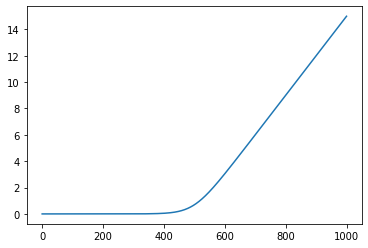

In [9]:
plt.plot(observationTimes)

In [12]:
cumSolArrayGPU = torch.from_numpy(cumSolArray).to(config.device)
brTableGPU = torch.from_numpy(np.ravel(brTable)).to(config.device)
observationTimeGPU = torch.from_numpy(observationTimes).to(config.device)
#weightsGPU = torch.from_numpy( np.exp(-observationTimes)/(1-np.exp(-observationTimes))  ).to(config.device)

eobservationTimes = np.hstack([0, observationTimes])

offset = 0.01
s = np.hstack((0,observationTimes[:-1]))
t = np.copy(observationTimes)
samplingProb = np.clip( np.exp(-t)*(1.-np.exp(-t)), offset, np.inf)
samplingProb /= np.sum(samplingProb)
weightsGPU = torch.from_numpy((np.exp(-s)-np.exp(-t))/np.clip( np.exp(-t)*(1.-np.exp(-t)), offset, np.inf)).to(config.device)
weightsGPU /= torch.sum(weightsGPU)

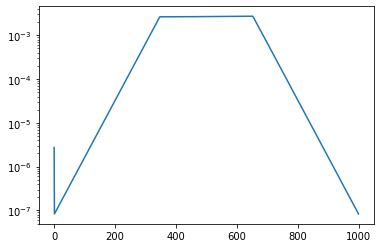

In [13]:
plt.plot( weightsGPU.detach().cpu().numpy() )
plt.gca().set_yscale('log')

### Noisifier

In [14]:
torch.cuda.set_device(config.device)

In [15]:
def generateBatchDataGPU(imgBatch,T):
    
    #imgBatch = torch.from_numpy(next(eval_iter)['image']._numpy())

    with torch.no_grad():

        n,nx,ny,nc = imgBatch.shape
        imgBatchGPU = (255*imgBatch).to(config.device).long()
        tIndex = torch.from_numpy(np.random.choice(T, size=(n,1,1,1), p=samplingProb)).to(config.device)
        #tIndex = (T*torch.cuda.FloatTensor(n,1,1,1).uniform_()).floor_().to(config.device)
        
        cp = cumSolArrayGPU[(tIndex+1).long(),:,imgBatchGPU.long()]
        #u = torch.from_numpy(np.random.random(size=(n,nx,ny,nc,1))).to(config.device)
        u = torch.cuda.FloatTensor(n,nx,ny,nc,1).uniform_().to(config.device)
        
        nt =  torch.argmax((u < cp).long(), axis=4).int()
        index = imgBatchGPU*256*T + nt*T + tIndex.long()
        birthRateBatch = brTableGPU[index.long()]  
    
        p = torch.exp(-observationTimeGPU[tIndex.long()])
        width = 1.0 #(255.0/2*p).reshape((n, 1, 1, 1))
        mean_v = (255.0/2*p).reshape((n, 1, 1, 1))
        
        #return (nt/255.*2.-1.).permute((0,3,1,2)), birthRateBatch.permute((0,3,1,2)), tIndex[:,0,0,0]
        return ((nt-mean_v)/width).permute((0,3,1,2)).to(torch.float32), birthRateBatch.permute((0,3,1,2)).to(torch.float32), tIndex[:,0,0,0]

### Visualize one batch

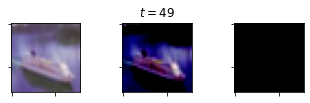

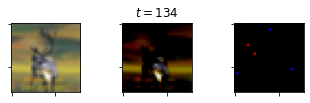

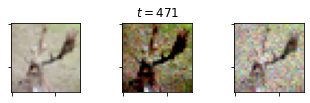

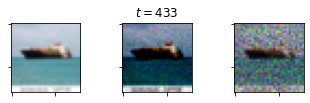

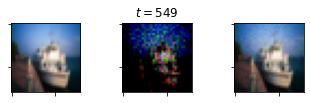

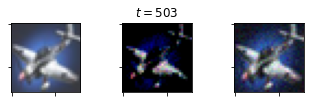

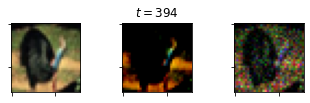

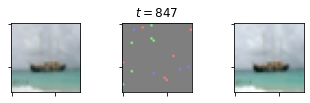

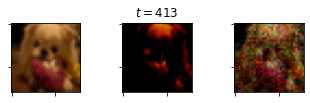

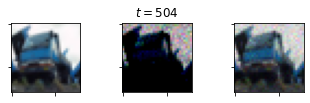

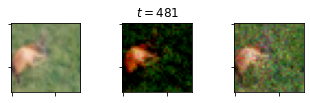

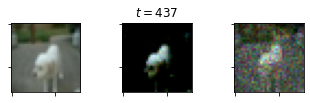

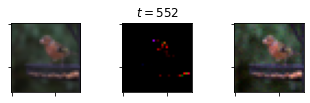

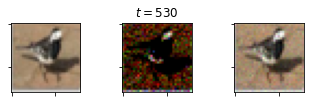

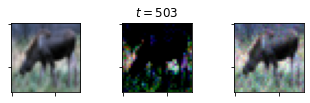

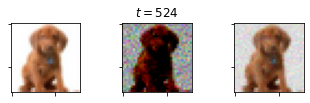

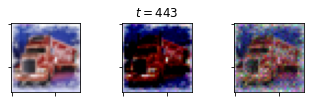

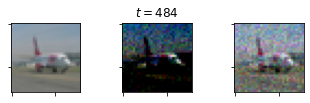

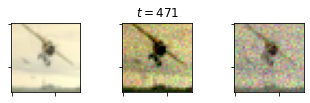

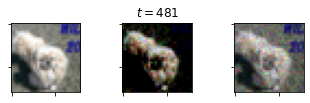

In [16]:
train_batch = next(train_iter)['image']._numpy()
train_batch_GPU = torch.from_numpy(train_batch)

output_image_batch, brRate_batch, tIndexArray = generateBatchDataGPU(train_batch_GPU, T)

output_image_batch = np.transpose(output_image_batch.detach().cpu().numpy(), (0,2,3,1))
brRate_batch = np.transpose(brRate_batch.detach().cpu().numpy(), (0,2,3,1))
tIndexArray = tIndexArray.detach().cpu().numpy()

for i in range(20):
    
    testImage = train_batch[i,:,:,:]
    
    
    output_image = (255.0*(output_image_batch[i,:,:,:]+1.)/2.).astype('int32')
    birthRate = brRate_batch[i,:,:,:]
    targetTime = tIndexArray[i]
    
    fig, ax = plt.subplots(1,3, figsize=(4.8,1.5))
    
    ax[0].imshow(testImage)
    
    if np.amax(output_image)!=0:
        ax[1].imshow(output_image/np.amax(output_image))
    else:
        ax[1].imshow(output_image)
        
    ax[1].set_title('$t='+str(targetTime)+'$')
    
    if np.amax(birthRate)-np.amin(birthRate)!=0:
        ax[2].imshow((birthRate-np.amin(birthRate))/(np.amax(birthRate)-np.amin(birthRate)))
    else:
        ax[2].imshow(birthRate)
        
    for j in range(3):
        
        ax[j].set_xticklabels('')
        ax[j].set_yticklabels('')
    
    fig.tight_layout()

In [21]:
ls dataBuffer

cifar10/  downloads/


### Instantiate an ML model to learn the transition rate

In [17]:
score_model = mutils.create_model(config)
score_fn = mutils.get_model_fn(score_model, train=True)
optimizer = torch.optim.Adam(score_model.parameters(),lr=config.optim.lr) 

ema = ExponentialMovingAverage(score_model.parameters(), decay=config.model.ema_rate)

train_batch = torch.from_numpy(next(train_iter)['image']._numpy()).to(config.device).float()
train_batch = train_batch.permute(0, 3, 1, 2)
imgBatch = scaler(train_batch)

workdir = 'linearDegradation-cifar10-MLE-v2'

state = dict(optimizer=optimizer, model=score_model, ema=ema, lossHistory=[], evalLossHistory=[], step=0)

checkpoint_dir = os.path.join(workdir, "checkpoints")
checkpoint_meta_dir = os.path.join(workdir, "checkpoints-meta", "checkpoint.pth")
tf.io.gfile.makedirs(checkpoint_dir)
tf.io.gfile.makedirs(os.path.dirname(checkpoint_meta_dir))
state = restore_checkpoint(checkpoint_meta_dir, state, config.device)
initial_step = int(state['step'])
lossHistory = state['lossHistory']
evalLossHistory = state['evalLossHistory']

### Training

In [ ]:
for step in range(initial_step, config.training.n_iters):
    
    train_batch = torch.from_numpy(next(train_iter)['image']._numpy())
    output_image_batch, birthRate_batch, tIndexArray = generateBatchDataGPU(train_batch, T)
    
    optimizer.zero_grad()

    y = relu(score_fn(output_image_batch, tIndexArray))
    
    #loss = torch.mean( ((birthRate_batch==0)*y + 0.5*(birthRate_batch!=0)*torch.square(y-birthRate_batch)/(birthRate_batch+1.0e-8)))
    #loss = torch.mean( weightsGPU[tIndexArray.long()].reshape([config.training.batch_size,1,1,1])*((birthRate_batch==0)*y + 0.5*(birthRate_batch!=0)*torch.square(y-birthRate_batch)/(birthRate_batch+1.0e-8)))
    loss = torch.mean( weightsGPU[tIndexArray.long()].reshape([config.training.batch_size,1,1,1])*(y - birthRate_batch*torch.log(y)))
    #loss = torch.mean(torch.square(y - birthRate_batch))
    
    loss.backward()

    state['ema'].update(state['model'].parameters())
    
    optimizer.step()
    
    lossHistory.append(loss.detach().cpu().numpy())

    if step != 0 and step % config.training.snapshot_freq_for_preemption == 0:
        save_checkpoint(checkpoint_meta_dir, state)
        
    if step != 0 and step % config.training.snapshot_freq == 0 or step == config.training.n_iters:
        save_step = step // config.training.snapshot_freq
        save_checkpoint(os.path.join(checkpoint_dir, f'checkpoint_{save_step}.pth'), state)    
    
    if np.mod(step, config.training.log_freq)==0:
        
        eval_batch = torch.from_numpy(next(eval_iter)['image']._numpy())
        output_image_batch, birthRate_batch, tIndexArray = generateBatchDataGPU(eval_batch, T)

        ema.store(score_model.parameters())
        ema.copy_to(score_model.parameters())
        
        y = relu(score_fn(output_image_batch, tIndexArray))
        #loss = torch.mean( weightsGPU[tIndexArray.long()].reshape([config.training.batch_size,1,1,1])*((birthRate_batch==0)*y + 0.5*(birthRate_batch!=0)*torch.square(y-birthRate_batch)/(birthRate_batch+1.0e-8)))
        #loss = torch.mean( ((birthRate_batch==0)*y + 0.5*(birthRate_batch!=0)*torch.square(y-birthRate_batch)/(birthRate_batch+1.0e-8)))
        #loss = torch.mean(y - birthRate_batch*torch.log(y))
        #loss = torch.mean(torch.square(y - birthRate_batch))
        loss = torch.mean( weightsGPU[tIndexArray.long()].reshape([config.training.batch_size,1,1,1])*(y - birthRate_batch*torch.log(y)))
    
        ema.restore(score_model.parameters())
        
        evalLossHistory.append(loss.detach().cpu().numpy())

        print(f'current iter: {step}, loss: {lossHistory[-1]}, eval loss: {evalLossHistory[-1]}')
        
    state['step'] = step
    state['lossHistory'] = lossHistory
    state['evalLossHistory'] = evalLossHistory
    
    gc.collect()
    torch.cuda.empty_cache()